# Excitation-number-restricted states: Jaynes-Cummings Chain

Authors: Robert Johansson (jrjohansson@gmail.com), Neill Lambert (nwlambert@gmail.com), Maximilian Meyer-Mölleringhof (m.meyermoelleringhof@gmail.com)

## Introduction

The ENR functions construct a basis set for multipartite systems which contains only states that have an overall number of excitations.
This is particularly useful for systems where the model conserves excitation number, as in the JC-chain example below.

We can see this by considering a system consisting of 4 modes, each with 5 states.
The total hilbert space size is $5^4 = 625$.
If we are only interested in states that contain up to 2 excitations, we only need to include states such as


    (0, 0, 0, 0)
    (0, 0, 0, 1)
    (0, 0, 0, 2)
    (0, 0, 1, 0)
    (0, 0, 1, 1)
    (0, 0, 2, 0)
    ...

The ENR fucntions create operators and states for the 4 modes that act within this state space.
For example,

```python
a1, a2, a3, a4 = enr_destroy([5, 5, 5, 5], excitations=2)
```

creates destruction operators for each mode.
From this point onwards, the annihiltion operators a1, ..., a4 can be used to setup a Hamiltonian, collapse operators and expectation-value operators, etc., following the usual pattern.

In this example we outline the advantage of ENR states by comparing them with the regular qutip implementation.
For this we calculate the time evolution and the partial trace for each and see consistent results with notable performance improvements.

#### Be aware!

Many default functions in QuTiP will fail on states and operators constructed with this method.
Additionally, using this formalism, annihilation and creation operators of different sub-systems no longer commute.
Therefore, when constructing Hamiltonians, annihilation operators must be on the right and creation operators on the left (see the offical publication for QuTiP v5 for more info). 
To find all available functions to work with ENR states see [Energy Restricted Operators in the official documentation](https://qutip.readthedocs.io/en/qutip-5.0.x/apidoc/functions.html#module-qutip.core.energy_restricted).

In [1]:
import numpy as np
from qutip import (Qobj, about, basis, destroy, enr_destroy, enr_fock,
                   enr_state_dictionaries, identity, liouvillian, mesolve,
                   plot_expectation_values, tensor)
from qutip.core.energy_restricted import EnrSpace

%matplotlib inline

## The Jaynes-Cumming Chain

The general Jaynes-Cumming model describes a single two-level atom interacting with a single electromagnetic cavity mode.
For this example, we put multiple of these systems in a chain and let them interact with neighbouring systems via their cavities.
We use $a_i$ ($a^\dag_i$) as annihilation (creation) operators for the cavity $i$ and $s_i$ ($s^\dag_i$) for the atoms.
We then model the complete Hamiltonian by splitting it into the individual systems:

$H_0 = \sum_{i=0}^{N} a_i^\dag a_i + s_i^\dag s_i$,

the atom-cavity interactions:

$H_{int,AC} = \sum_{i=0}^{N} = \frac{1}{2} (a_i^\dag s_i + s_i^\dag a_i)$,

and the cavity-cavity interactions:

$H_{int,CC} = \sum_{i=0}^{N-1} 0.9 \cdot (a_i^\dag a_{i+1} + a_{i+1}^\dag a_{i})$,

where the interaction strength of $0.9$ was chosen arbitrarily.

### Problem paramters

In [2]:
N = 4  # number of systems
M = 2  # number of cavity states
dims = [M, 2] * N  # dimensions of JC spin chain
excite = 1  # total number of excitations
init_excite = 1  # initial number of excitations

### Setup to Calculate Time Evolution

In [3]:
def solve(d, psi0):
    # annihilation operators for cavity modes
    a = d[::2]
    # atomic annihilation operators
    sm = d[1::2]

    # notice the ordering of annihilation and creation operators
    H0 = sum([aa.dag() * aa for aa in a]) + sum([s.dag() * s for s in sm])

    # atom-cavity couplings
    Hint_ac = 0
    for n in range(N):
        Hint_ac += 0.5 * (a[n].dag() * sm[n] + sm[n].dag() * a[n])

    # cavity-cavity couplings
    Hint_cc = 0
    for n in range(N - 1):
        Hint_cc += 0.9 * (a[n].dag() * a[n + 1] + a[n + 1].dag() * a[n])

    H = H0 + Hint_ac + Hint_cc

    e_ops = [x.dag() * x for x in d]
    c_ops = [0.01 * x for x in a]

    times = np.linspace(0, 250, 1000)
    L = liouvillian(H, c_ops)
    opt = {"nsteps": 5000, "store_states": True}
    result = mesolve(H, psi0, times, c_ops, e_ops, options=opt)
    return result, H, L

### Regular QuTiP States and Operators

In [4]:
d = [
    tensor(
        [
            destroy(dim1) if idx1 == idx2 else identity(dim1)
            for idx1, dim1 in enumerate(dims)
        ]
    )
    for idx2, _ in enumerate(dims)
]
psi0 = tensor(
    [
        basis(dim, init_excite) if idx == 1 else basis(dim, 0)
        for idx, dim in enumerate(dims)
    ]
)

Regular operators of different systems commute as they belong to different Hilbert spaces.
Example:

In [5]:
d[0].dag() * d[1] == d[1] * d[0].dag()

True

Solving the time evolution:

In [6]:
res1, H1, L1 = solve(d, psi0)
print(f"Run time: {res1.stats['run time']}s")

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Run time: 17.778555393218994s


### Using ENR States and Operators

In [7]:
d_enr = enr_destroy(dims, excite)
init_enr = [init_excite if n == 1 else 0 for n in range(2 * N)]
psi0_enr = enr_fock(dims, excite, init_enr)

Using ENR states forces us to give up on the standard tensor structure of multiple Hilbert spaces.
Operators for different systems therefore generally no longer commute:

In [8]:
d_enr[0].dag() * d_enr[1] == d_enr[1] * d_enr[0].dag()

False

Solving the time evolution:

In [9]:
res2, H2, L2 = solve(d_enr, psi0_enr)
print(f"Run time: {res2.stats['run time']}s")

Run time: 0.058690786361694336s


### Comparison of Expectation Values

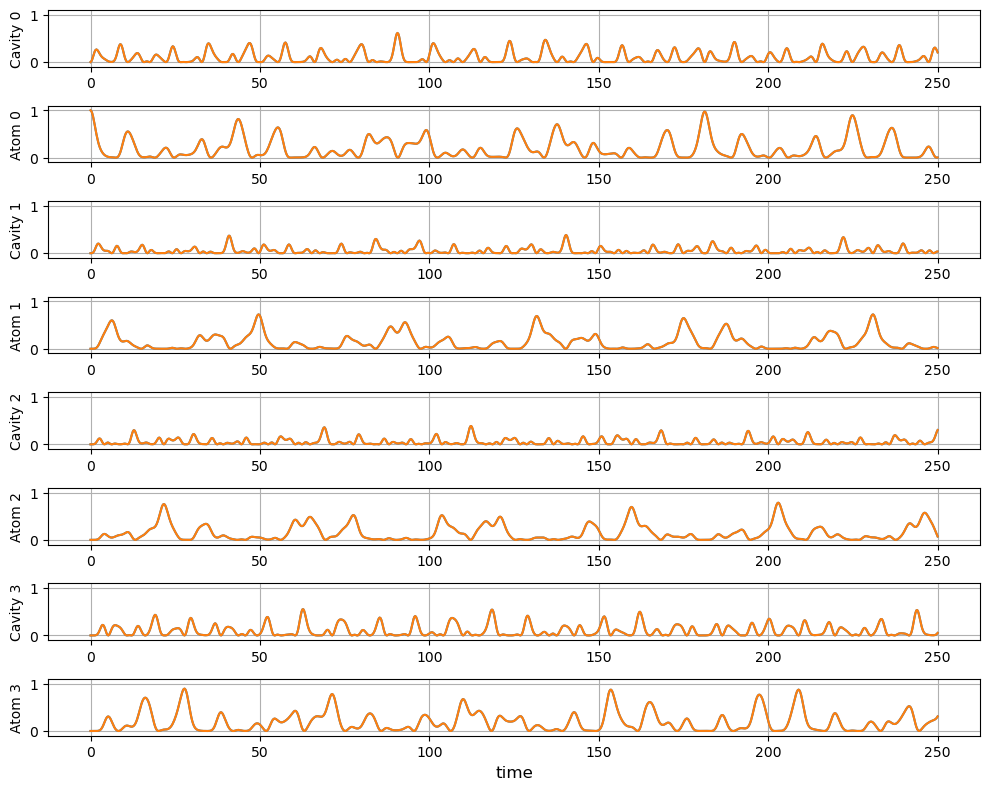

In [10]:
fig, axes = plot_expectation_values([res1, res2])
fig.set_figwidth(10)
fig.set_figheight(8)
for idx, ax in enumerate(axes):
    if idx % 2:
        ax.set_ylabel(f"Atom {idx//2}")
    else:
        ax.set_ylabel(f"Cavity {idx//2}")
    ax.set_ylim(-0.1, 1.1)
    ax.grid()
fig.tight_layout()

### Calculation of Partial Trace

The usage of ENR states makes many standard QuTiP features fail.
*ptrace* is one of those.
Below we demonstrate how the partial trace for ENR states can be calculated and show the corresponding result together with the standrad QuTiP approach.

In [11]:
def ENR_ptrace(rho, sel, excitations):
    if isinstance(sel, int):
        sel = np.array([sel])
    else:
        sel = np.asarray(sel)

    if (sel < 0).any() or (sel >= len(rho.dims[0])).any():
        raise TypeError("Invalid selection index in ptrace.")

    drho = rho.dims[0]
    _, state2idx, _ = enr_state_dictionaries(drho, excitations)

    dims_short = np.asarray(drho).take(sel).tolist()
    nstates2, state2idx2, _ = enr_state_dictionaries(dims_short, excitations)

    # construct new density matrix
    rhout = np.zeros((nstates2, nstates2), dtype=np.complex64)
    # dimensions of traced out system
    rest = np.setdiff1d(np.arange(len(drho)), sel)
    for state in state2idx:
        for state2 in state2idx:
            # add diagonal elements to the new density matrix
            state_red = np.asarray(state).take(rest)
            state2_red = np.asarray(state2).take(rest)
            if np.all(state_red == state2_red):
                rhout[
                    state2idx2[tuple(np.asarray(state).take(sel))],
                    state2idx2[tuple(np.asarray(state2).take(sel))],
                ] += rho[state2idx[state], state2idx[state2]]

    new_dims = np.asarray(drho).take(sel).tolist()
    return Qobj(rhout, dims=[EnrSpace(new_dims, excite)] * 2)

In [12]:
res1.states[10].ptrace(1)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.73127189 0.        ]
 [0.         0.26872811]]

In [13]:
ENR_ptrace(res2.states[10], 1, excite)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.73127323 0.        ]
 [0.         0.26872677]]

In [14]:
res1.states[10].ptrace([0, 1, 4])

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.40855837+0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.12078099+0.j          0.        +0.18014843j
   0.        +0.j         -0.15616905+0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        -0.18014843j  0.26872811+0.j
   0.        +0.j          0.        +0.23295012j  0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j         -0.15616905+0.j          0.        -0.23295012j
   0.        +0.j          0.20193253+0.j          0.        +0.j
   0.      

In [15]:
ENR_ptrace(res2.states[10], [0, 1, 4], excite)

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.40856433+0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.12076794+0.j          0.        +0.18014826j
  -0.15616585+0.j        ]
 [ 0.        +0.j          0.        -0.18014826j  0.26872677+0.j
   0.        +0.2329527j ]
 [ 0.        +0.j         -0.15616585+0.j          0.        -0.2329527j
   0.20194095+0.j        ]]

## About

In [16]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.2.0.dev0+4033695
Numpy Version:      2.2.4
Scipy Version:      1.15.2
Cython Version:     3.0.12
Matplotlib Version: 3.10.1
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          Generic
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------



qutip-jax: 0.1.1.dev5
qutip-qtrl: 0.2.0.dev0+acb71a0
qutip-qip: 0.5.0.dev0+d58a82d

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


## Testing

In [17]:
assert np.allclose(
    res1.states[10].ptrace([1]).full(),
    ENR_ptrace(res2.states[10], [1], excite).full(),
), "The approaches do not yield the same result."